In [6]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


Step 1. Define the parameters according to (Stephan et al., 2007)

In [3]:
V0 = 0.04
theta0= 40.3
epsilon = 1
k=0.6
E0= 0.4
TE= 0.04
r0= 25
k1=4.3*theta0*E0*TE
k2= epsilon*r0*E0*TE
k3 = 1- epsilon
gamma = 0.32
tau = 1
alpha = 0.32

Step 2. Define State-space matrices A, B, C

In [19]:

A = np.array([
    [-k, -gamma, 0, 0],
    [1, 0, 0, 0],
    [0, 1/tau, -1/(alpha*tau), 0],
    [0, (E0 - (E0 - 1) * np.log(1 - E0)) / (E0 * tau), (alpha-1)/(alpha*tau), -1/tau]
])

B = np.array([
    [1],
    [0],
    [0],
    [0]
])

C = np.array([
    [0, 0, V0 * (k2-k3), V0 * (-k1 - k2)]
])

Step 3: Define Transfer Function （eq 22)

In [8]:
def transfer_function(V0, E0, k1, k2, k3, alpha, tau, gamma, k, omega=np.linspace(0.01, np.pi, 100)):
    s = 1j * omega  # s = i * omega
    numerator = V0 * (
            (E0 - 1) * np.log(1 - E0) * (k1 + k2) * (alpha * s * tau + 1)
            - alpha * E0 * (k1 + k3) * (s * tau + 1)
    )
    denominator = (
            E0 * (s * tau + 1) * (gamma + s * (k + s)) * (alpha * s * tau + 1)
    )
    H_s = numerator / denominator
    return H_s

omega = np.linspace(0.01, np.pi, 100)
H_values = transfer_function(V0, E0, k1, k2, k3, alpha, tau, gamma, k, omega)

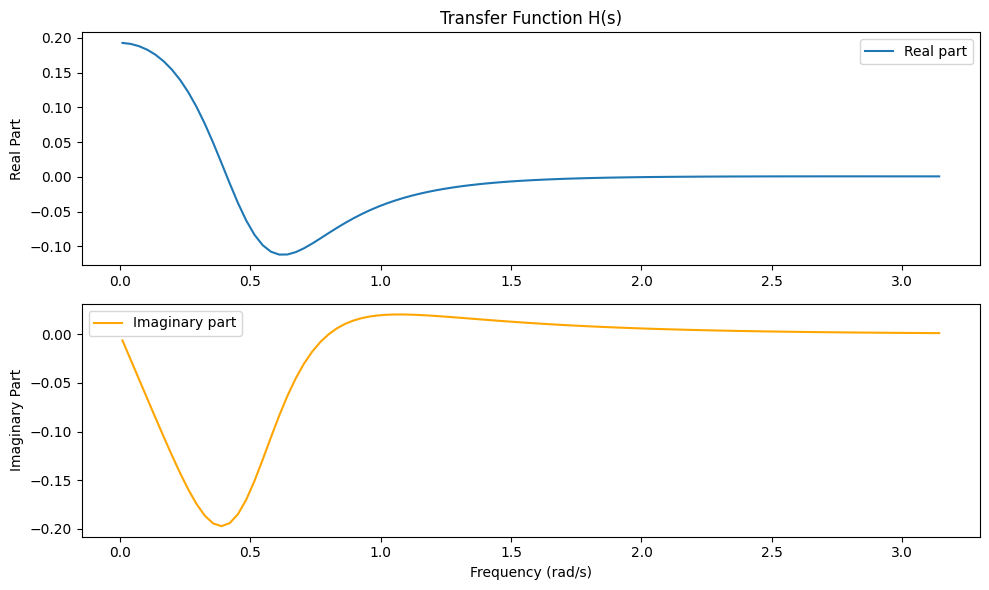

In [9]:
# Plot transfer function real and imaginary parts
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(omega, H_values.real, label="Real part")
plt.title("Transfer Function H(s)")
plt.ylabel("Real Part")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(omega, H_values.imag, label="Imaginary part", color="orange")
plt.ylabel("Imaginary Part")
plt.xlabel("Frequency (rad/s)")
plt.legend()
plt.tight_layout()
plt.show()

Step 4. Define G_y(w), G_v(w) & G_e(w)

Compute the transfer function values (H_omega_values) and convert them into a complex PyTorch tensor (H_omega). Similarly, the state-space matrix A is converted to complex format to ensure compatibility in subsequent complex-valued operations.

In [20]:
H_omega_values = transfer_function(V0, E0, k1, k2, k3, alpha, tau, gamma, k, omega)
H_omega = torch.tensor(H_omega_values, dtype=torch.complex64)

A = torch.tensor(A, dtype=torch.complex64)

num_freq = len(omega)

def compute_Gy(omega, A, H_omega, G_v, G_e):
    """
    Computes the cross-spectral density (CSD) G_y(omega) for each frequency in omega.
    """
    
    I = torch.eye(A.shape[0], dtype=torch.complex64)  # Identity matrix 
    num_freq = len(omega)
    G_y_omega = torch.zeros((num_freq, A.shape[0], A.shape[0]), dtype=torch.complex64)

    # Loop through each frequency and compute G_y(w)
    for i, w in enumerate(omega):
        H_w = H_omega[i]  # H_omega for the current frequency
        
        term_1 = torch.inverse(1j * w * I - A)
        term_2 = torch.inverse(-1j * w * I - A.T.conj())

        G_v_w = G_v[i]
        G_e_w = G_e[i]

        # Create diagonal matrices where the diagonal elements are the power spectral densities for that frequency, while the off-diagonal elements are zero because we assume that these fluctuations and noise are independent for each state variable.
        G_v_matrix = G_v_w * torch.eye(A.shape[0], dtype=torch.complex64) 
        G_e_matrix = G_e_w * torch.eye(A.shape[0], dtype=torch.complex64)

        # Using eq 22 from Novelli
        G_y_w = H_w * (term_1 @ G_v_matrix @ term_2) * H_w.conj() + G_e_matrix
        G_y_omega[i] = G_y_w

    return G_y_omega

def compute_gv_ge(alpha_v, beta_v, alpha_e, beta_e, omega):
    # From power-law decay
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    G_v = alpha_v * omega_tensor ** (-beta_v)
    G_e = alpha_e * omega_tensor ** (-beta_e)
    return G_v, G_e